# Preparacion de datos

In [1577]:
import pandas as pd
import plotnine as pn

data_location= 'tweet_and_user_data.csv'

pd.options.display.max_columns = 500
tweet_data  = pd.read_csv(data_location, low_memory=False)
#tweet_data = pd.read_csv(data_location,low_memory=False)
%matplotlib inline


In [1578]:
# Creamos un conjunto de datos con agregaciones a nivel de usuario. Hacemos esto para generar unos datos nuevos para analizar despues.

unique = ['id', 'conversation_id', 'retweet_id']
avg = ['nlikes', 'nreplies', 'nretweets']

gby = ['id_user', 'username_user', 'join_date', 'following', 'followers', 'likes', 'media', 'location', 'verified']

agg = {col : 'nunique' if col in unique else 'mean' for col in unique + avg}

tweet_data['location'] = tweet_data.location.fillna('')

user_stats = tweet_data.groupby(gby).agg(agg).reset_index()

user_stats.head()

,id_user,username_user,join_date,following,followers,likes,media,location,verified,id,conversation_id,retweet_id,nlikes,nreplies,nretweets
0,12,jack,2006-03-21,4406,5656510,35242,2836,,True,74,48,18,1699.081081,155.418919,574.175676
1,13,biz,2006-03-21,1596,2669130,7152,911,"San Francisco, CA",True,7,5,1,13.000000,1.714286,1.714286
2,428333,cnnbrk,2007-01-02,119,61197525,27,17019,Everywhere,True,66,65,1,1631.545455,417.424242,424.303030
3,717313,arstechnica,2007-01-28,1330,1147218,8425,6238,NYC - Boston - Chicago - SF,True,111,111,11,22.675676,1.702703,10.153153
4,742143,BBCWorld,2007-02-01,18,32526661,13,25403,"London, UK",True,441,436,65,734.868481,103.995465,296.519274


In [1579]:
from sklearn.cluster import KMeans

#cogemos las variables a analizar
X_variables = ['followers', 'following', 'likes', 'media', 'join_date']


In [1580]:
#Si incluimos variables no numericas se gerará un error para evitar esto tenemos que transformar el campo 
#en este caso tenemos la fecha de creacion de la cuenta - vamos a convertir esto en un número de dias.
#veremos cuantos dias han apsado desde la creacion de la cuenta
user_stats['num_days_created'] = (pd.to_datetime('2022-01-01') - pd.to_datetime(user_stats.join_date)).dt.days
user_stats.num_days_created.describe()

count     847.000000
mean     4422.446281
std       622.065810
min       194.000000
25%      4217.500000
50%      4560.000000
75%      4705.500000
max      5765.000000
Name: num_days_created, dtype: float64

In [1581]:
X_variables = ['followers', 'following', 'likes', 'media', 'num_days_created']

In [1582]:
model = KMeans(n_clusters=3, random_state=0)
model.fit(user_stats[X_variables])
pd.DataFrame(model.predict(user_stats[X_variables])).value_counts()

0
0    785
2     52
1     10
Name: count, dtype: int64

## Pipeline

In [1584]:
#Pipeline es una forma de combinar varios pasos en uno
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [1585]:
X_variables = ['followers', 'following', 'likes', 'media', 'num_days_created']
#Aqui veremos un solo paso que es la clusterizacion
#pipeline recoge los diferentes metodos de otras funciones
kmeans_pipeline = Pipeline(
    [
        ('cluster', KMeans(n_clusters=5, random_state=0))
    ]
)

kmeans_pipeline.fit(user_stats[X_variables])
predictions = kmeans_pipeline.predict(user_stats[X_variables])
pd.DataFrame(predictions).value_counts()

0
0    556
4    187
3     60
2     36
1      8
Name: count, dtype: int64

In [1586]:
#calculamos el silohuette score
metrics.silhouette_score(user_stats[X_variables], predictions)

0.6078074941217609

## Eligiendo y normalizando variables

In [1588]:
#Buscamos en general variables continuas que sean continuas(sin muchos outliers) y con poca correlacion entre ellas 
potential_variables = [col for col in user_stats if user_stats[col].dtypes in [int, float, bool] and col not in ['id_user']]

In [1589]:
user_stats[potential_variables].describe()

,nlikes,nreplies,nretweets
count,8.470000e+02,847.000000,847.000000
mean,7.907931e+03,387.972089,1398.517748
std,6.969749e+04,4153.549018,17738.008372
min,0.000000e+00,0.000000,0.000000
25%,9.857193e+01,7.768319,21.750000
50%,5.157097e+02,31.950000,96.000000
75%,2.669773e+03,105.176471,460.209459
max,1.899711e+06,88035.000000,505932.333333


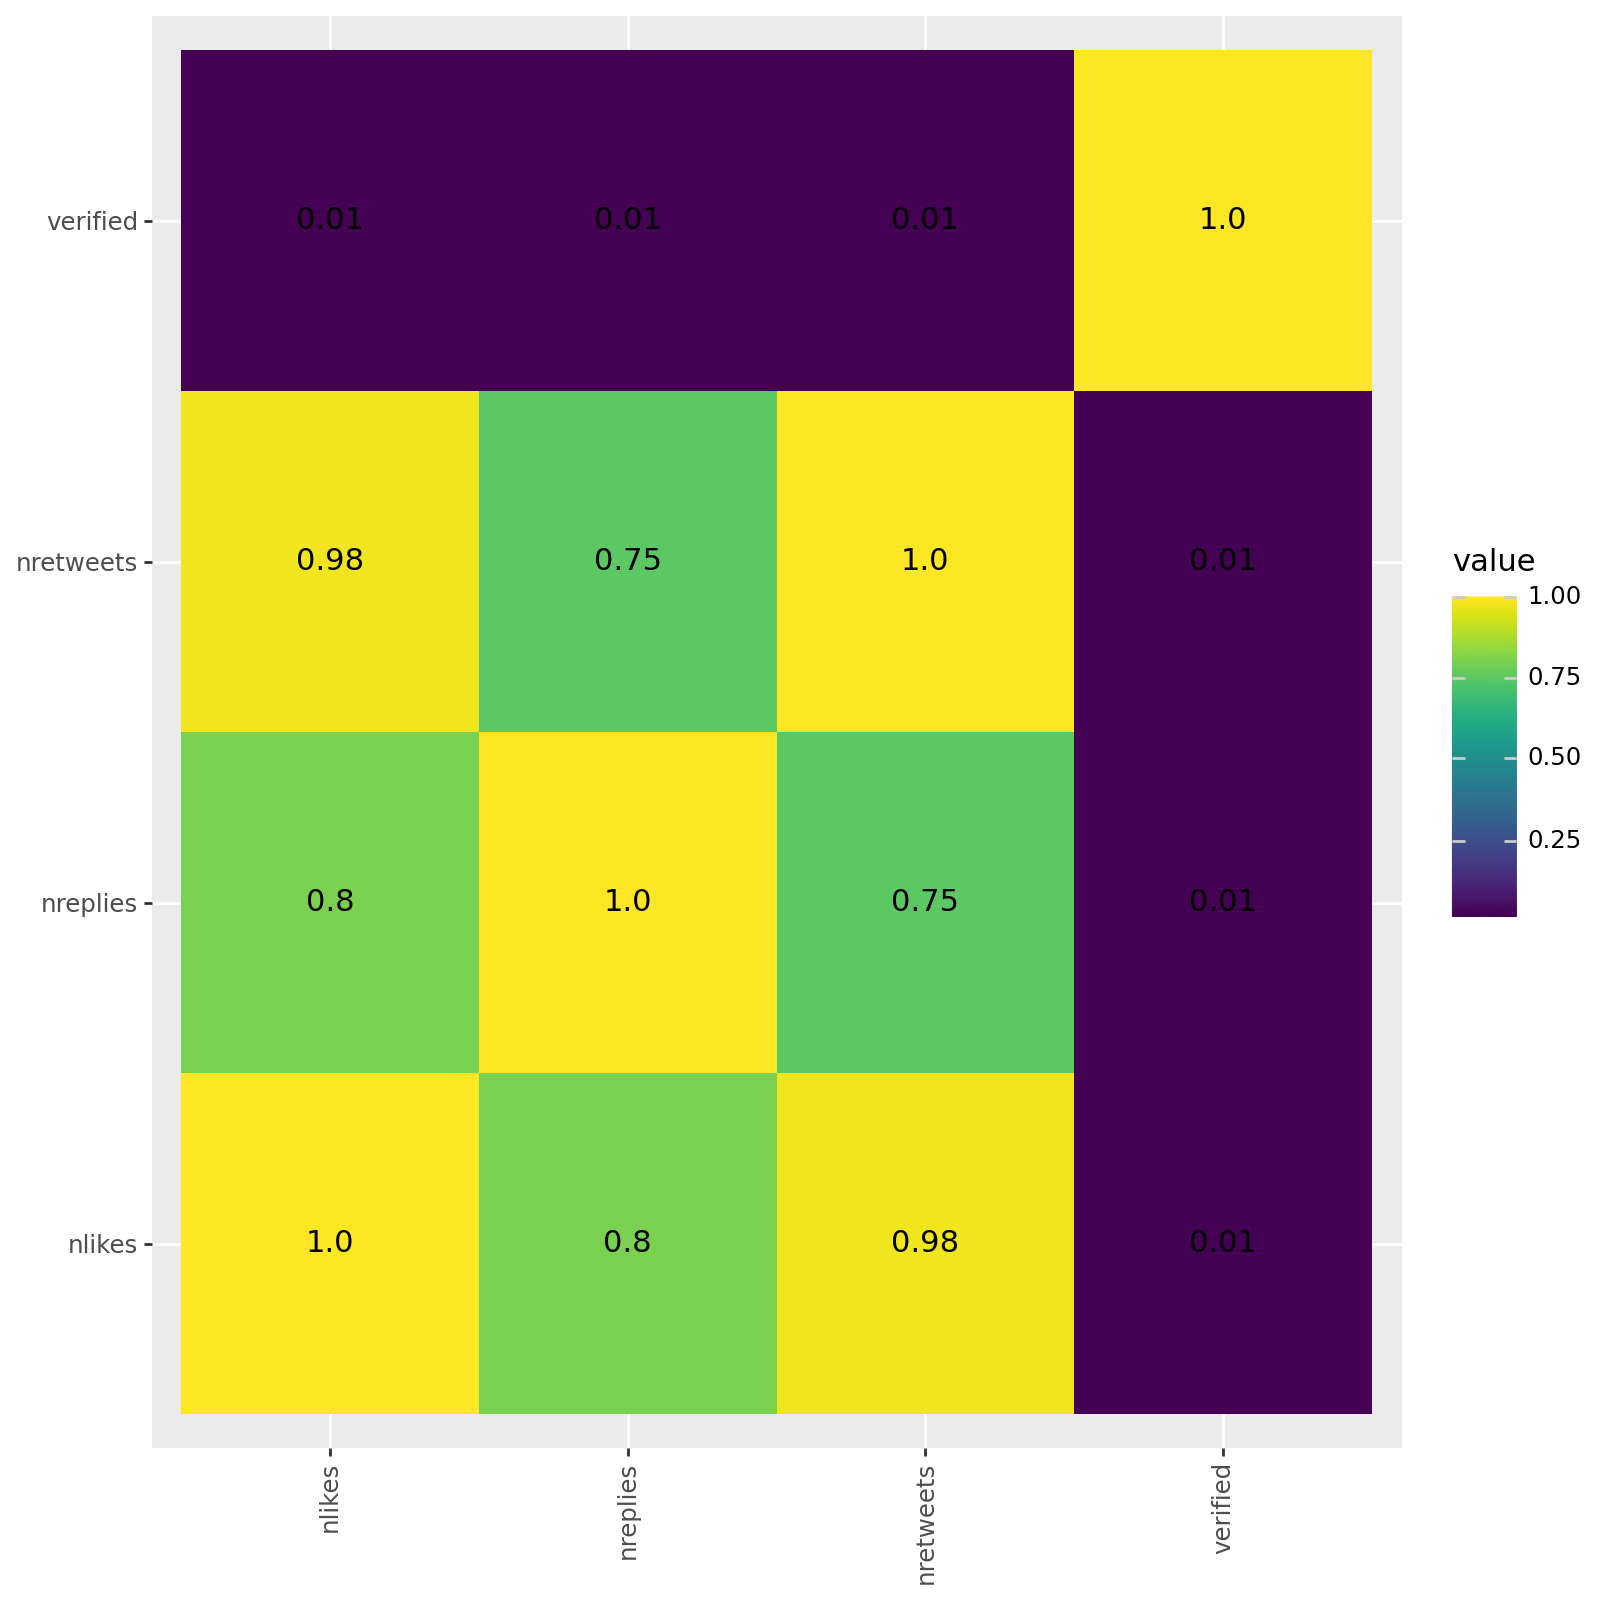

In [1590]:
#Este es un grafico bastante precuente de la correlacion de las variables
graph_data = pd.melt(user_stats[potential_variables].corr().round(2).reset_index(), 'index')
graph = (
    pn.ggplot(graph_data, pn.aes(x='index', y='variable', fill='value', label='value'))
    + pn.geom_tile()
    + pn.geom_text()
    + pn.theme(figure_size=(8, 8), axis_text_x=pn.element_text(angle=90))
    + pn.xlab('') + pn.ylab('')
)

graph

In [1591]:
#Primero nos centramos en normalizar para aprender la sintaxis de sklearn 

In [1592]:
#muchas de las funciones de preparacion de datos se encuentran dentro del modulo de preprocessing
from sklearn import preprocessing

variables = ['followers', 'num_days_created']
#las variables tienen rangos muy distintos
#debemos tener en cuenta que kmeans favorece las distancias  porque explota la distancia entre puntos
#si las variables tienen dimensiones diferentes, las distancias no son comparables
print('---- DISTRIBUCION ANTERIOR: ------------')
print(user_stats[variables].describe().round())
print('\n')

#el scaler funciona como si fuese un tipo de modelo
#una vez hecho el calculo del stanndars scaler y tenerlo almacenada lo podremos aplicar a nuevos datos externos sin tener que tocarlos
follower_scaler = preprocessing.StandardScaler()
follower_scaler.fit(user_stats[variables])

print('--------- DISTRIBUCION ACTUAL : ------------')
#aplicamos el standard scaler poniendo un transform porque estamos transformando los datos no prediciendolos.
print(pd.DataFrame(follower_scaler.transform(user_stats[variables])).describe().round())

---- DISTRIBUCION ANTERIOR: ------------
         followers  num_days_created
count        847.0             847.0
mean     8884093.0            4422.0
std     13361636.0             622.0
min          107.0             194.0
25%      2854442.0            4218.0
50%      4787665.0            4560.0
75%      9252669.0            4706.0
max    129909278.0            5765.0


--------- DISTRIBUCION ACTUAL : ------------
           0      1
count  847.0  847.0
mean    -0.0   -0.0
std      1.0    1.0
min     -1.0   -7.0
25%     -0.0   -0.0
50%     -0.0    0.0
75%      0.0    0.0
max      9.0    2.0


In [1593]:
#usaremos el standard scaler dentro de nuestro pipeline

X_variables = ['followers', 'following', 'likes', 'media', 'num_days_created']

kmeans_pipeline = Pipeline(
    [
        ('scaler', preprocessing.StandardScaler()),
        ('cluster', KMeans(n_clusters=5, random_state=0))
    ]
)
#se hará el fit del algoritmo y el fit del scaler
kmeans_pipeline.fit(user_stats[X_variables])
#de nuevo se hara el predict del algoritmo teniendo en cuenta el transform del scaler
predictions = kmeans_pipeline.predict(user_stats[X_variables])
pd.DataFrame(predictions).value_counts()

0
0    533
4    233
1     59
3     21
2      1
Name: count, dtype: int64

In [1594]:
#calculammos tambien el silhouette
metrics.silhouette_score(kmeans_pipeline['scaler'].transform(user_stats[X_variables]), predictions)

0.2836011049114757

In [1595]:
#convertimos a string simplemente para que en el grafico salgan las categorias

user_stats['predictions_kmeans_5_scaler'] = predictions.astype(str)

C:\Users\nuria\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log


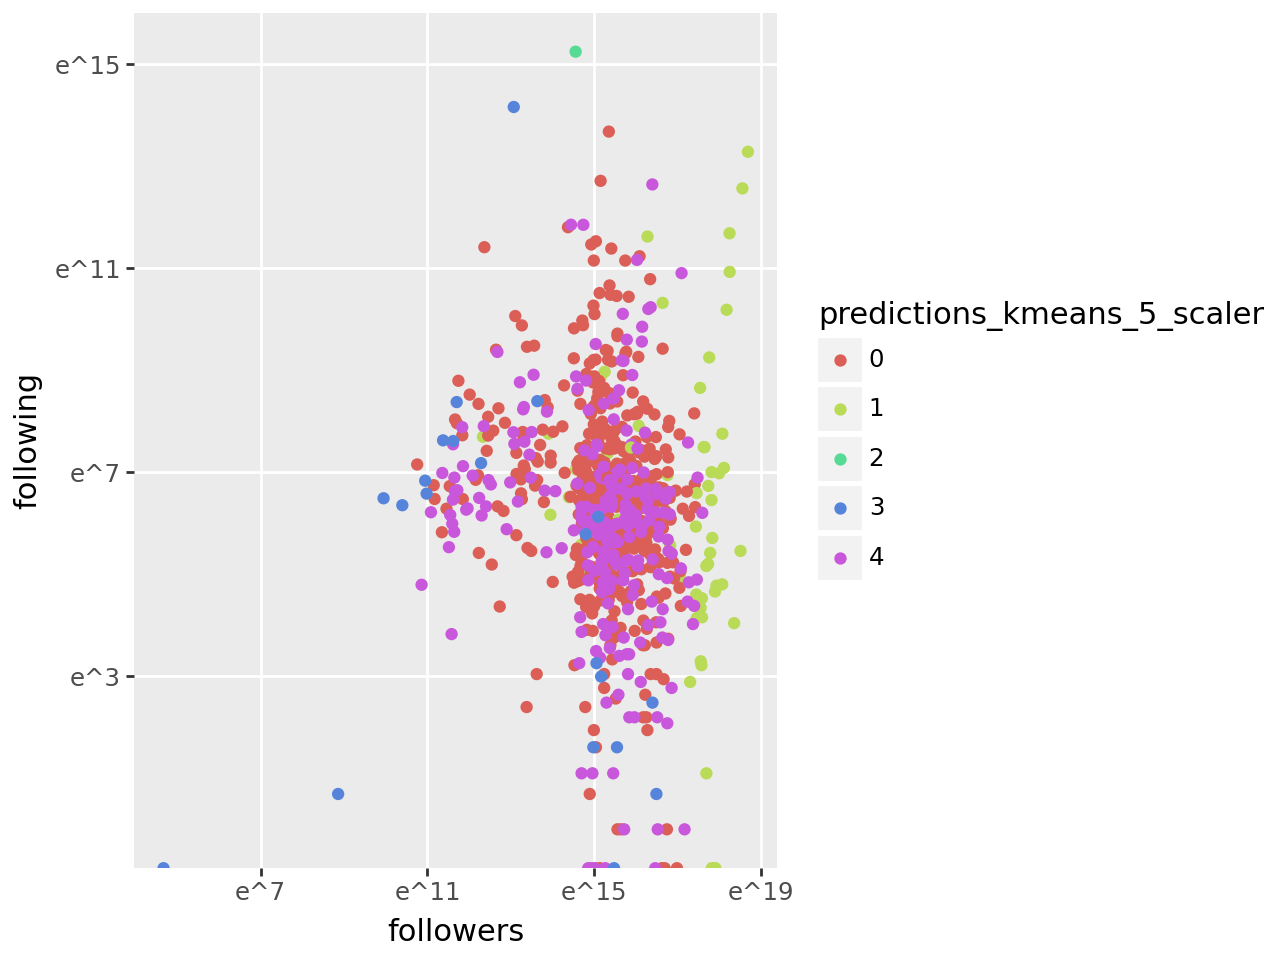

In [1596]:
#estamos usando plotnine que es una implementacion de ggplot en python
#creamos un grafico cogiendo las variables de followers y following
#pondremos un color en funcion del cluster predicho
#ponemos una escala logaritmica porque estamos trabajando con numeros muy grandes

graph = (
    pn.ggplot(user_stats, pn.aes(x='followers', y='following', color='predictions_kmeans_5_scaler'))
    + pn.geom_point()
    + pn.scale_x_continuous(trans='log')
    + pn.scale_y_continuous(trans='log')
)

graph

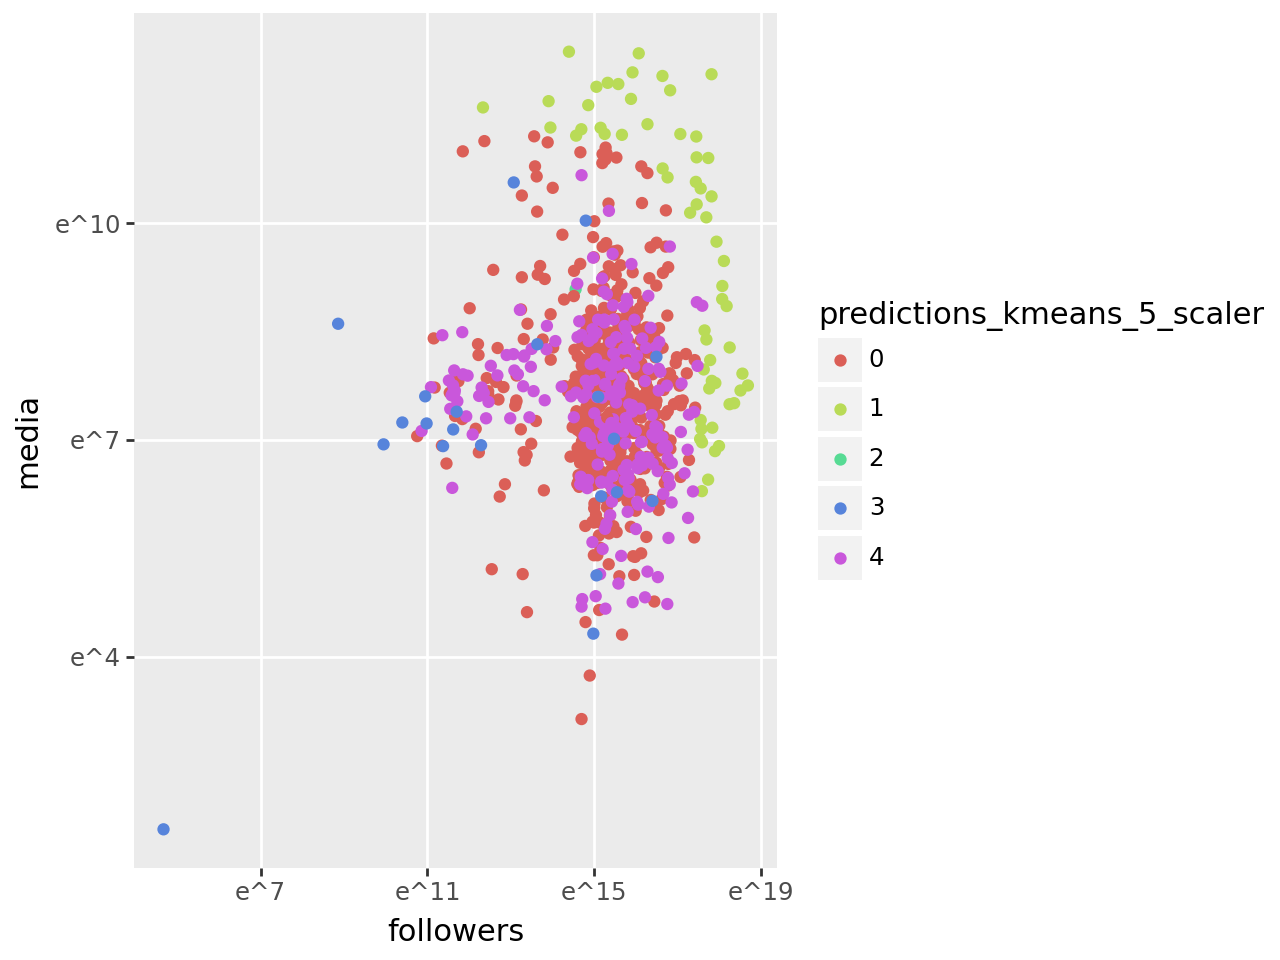

In [1597]:
#creamos un grafico cogiendo las variables de followers y media
graph = (
    pn.ggplot(user_stats, pn.aes(x='followers', y='media', color='predictions_kmeans_5_scaler'))
    + pn.geom_point()
    + pn.scale_x_continuous(trans='log')
    + pn.scale_y_continuous(trans='log')
)

graph

C:\Users\nuria\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log


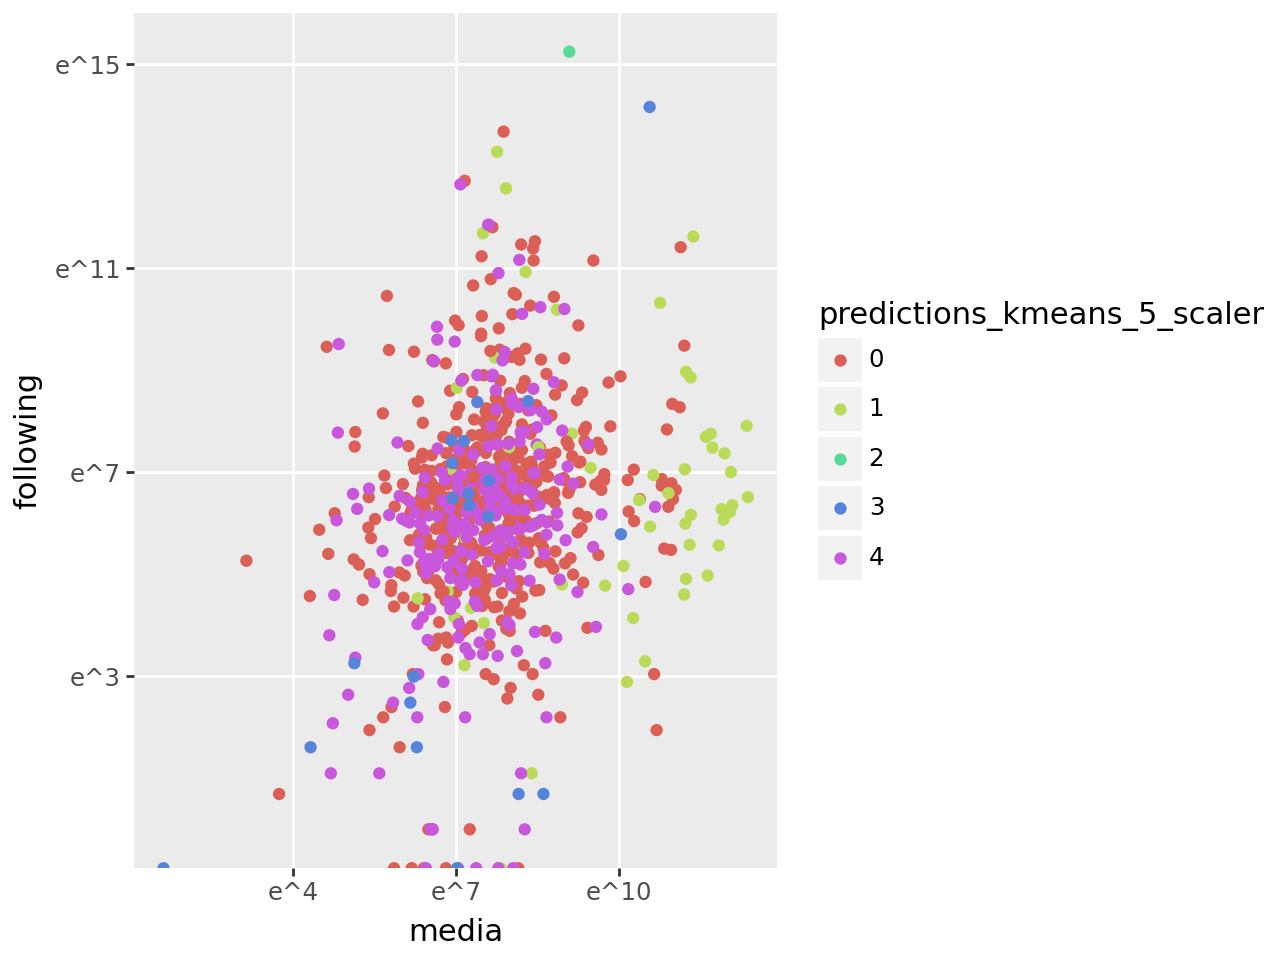

In [1598]:
#creamos un grafico cogiendo las variables demedia y following
graph = (
    pn.ggplot(user_stats, pn.aes(x='media', y='following', color='predictions_kmeans_5_scaler'))
    + pn.geom_point()
    + pn.scale_x_continuous(trans='log')
    + pn.scale_y_continuous(trans='log')
)

graph

# Otras técnicas de clusterización

In [1600]:
from sklearn.cluster import DBSCAN
#DBSCAN es un algoritmo similar a kmeans pero busca puntos de alta densidad
#Es capaz de detectar puntos que no pertenecen a ningun grupo
X_variables = ['followers', 'following', 'likes', 'media', 'num_days_created']
#aplicamos el scaler y aprovechamos el pipeline
dbscan_pipeline = Pipeline(
    [
        ('scaler', preprocessing.StandardScaler()),
        ('cluster', DBSCAN(0.8))
    ]
)

# no tiene metodo de predict, en cambio existe el metodo fit_predict
predictions = dbscan_pipeline.fit_predict(user_stats[X_variables])
pd.DataFrame(predictions).value_counts()
#en dbscan los puntos que estan en -1 significa que no tienen nigun cluster asignado
# formamos una serie de 2 clusters, los clusters 0 y 1
#El motivo detras de los resultados puede que sea que existen pocos clusters reales en los datos 
#KMeans puede estar creando clusters arbitrarios.

0 
 0    761
-1     64
 1     22
Name: count, dtype: int64

In [1601]:
#evaluamos con silhouette score
metrics.silhouette_score(dbscan_pipeline['scaler'].transform(user_stats[X_variables]), predictions)

0.5034866285582085

In [1602]:
user_stats['predictions_dbscan_scaler'] = predictions.astype(str)

C:\Users\nuria\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log


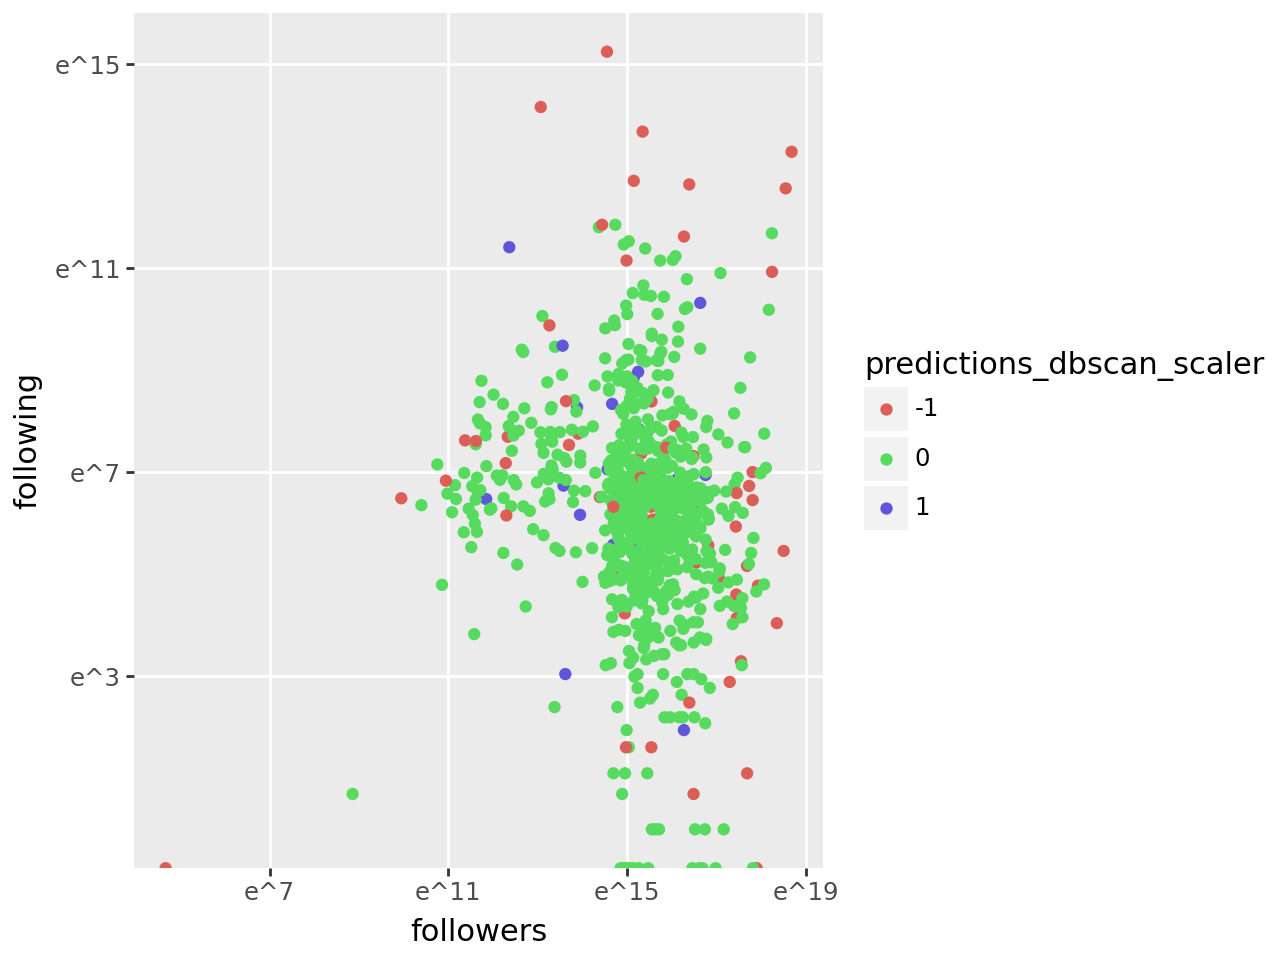

In [1603]:
#cluster -1 son puntos sin grupo

graph = (
    pn.ggplot(user_stats, pn.aes(x='followers', y='following', color='predictions_dbscan_scaler'))
    + pn.geom_point()
    + pn.scale_x_continuous(trans='log')
    + pn.scale_y_continuous(trans='log')
)

graph

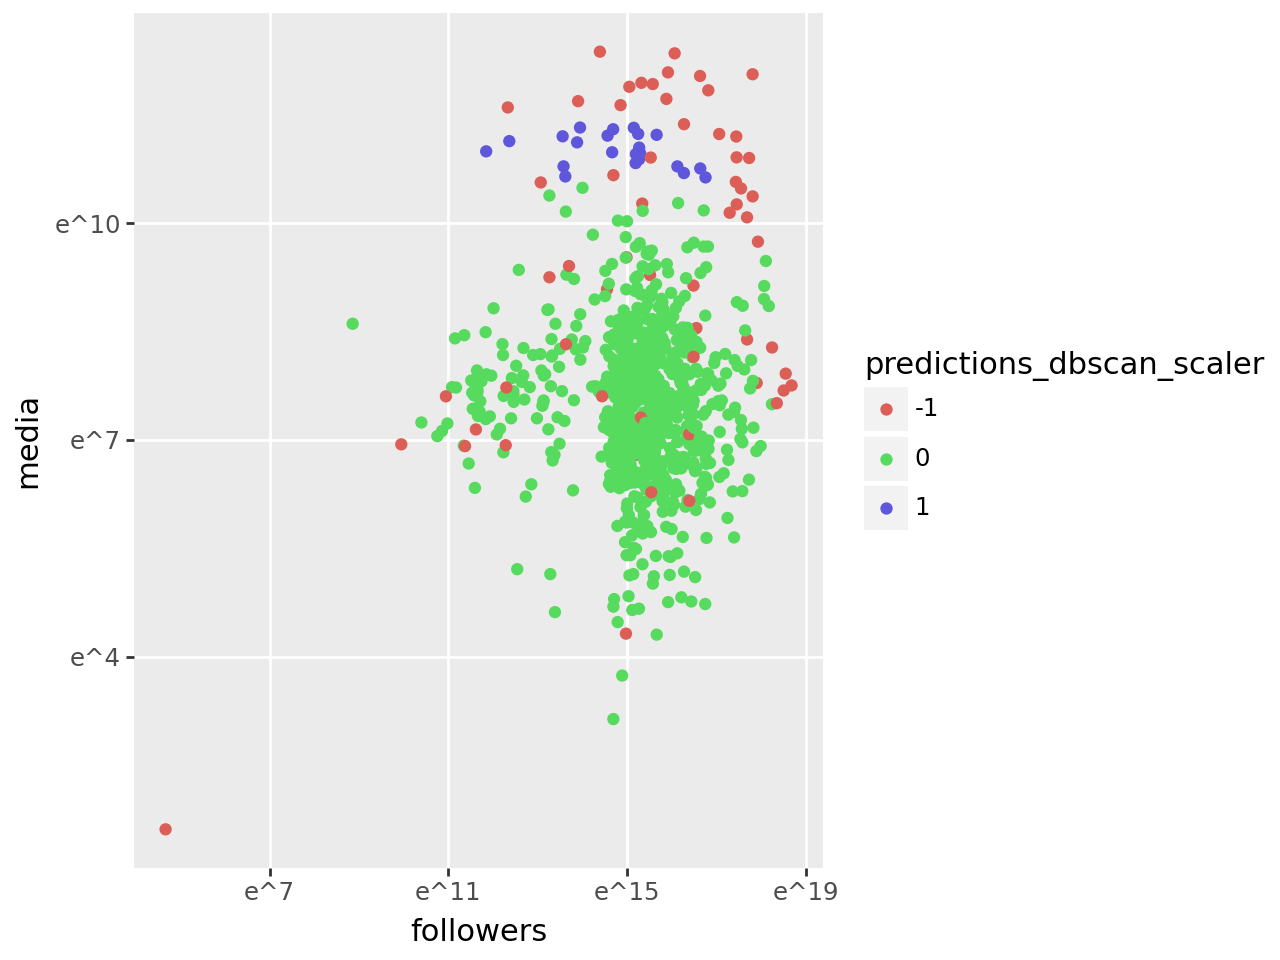

In [1604]:
graph = (
    pn.ggplot(user_stats, pn.aes(x='followers', y='media', color='predictions_dbscan_scaler'))
    + pn.geom_point()
    + pn.scale_x_continuous(trans='log')
    + pn.scale_y_continuous(trans='log')
)

graph

C:\Users\nuria\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log


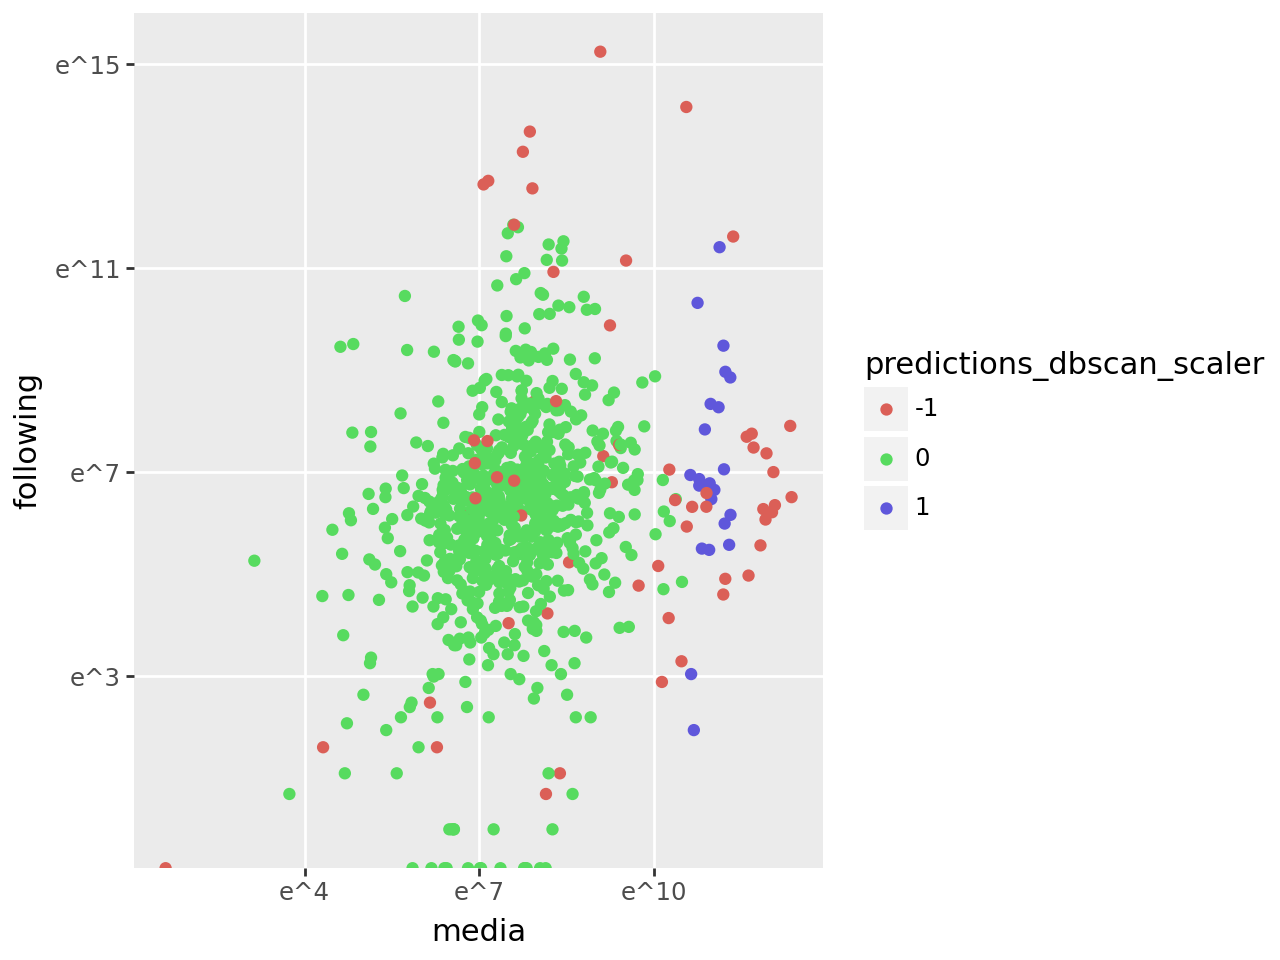

In [1605]:
graph = (
    pn.ggplot(user_stats, pn.aes(x='media', y='following', color='predictions_dbscan_scaler'))
    + pn.geom_point()
    + pn.scale_x_continuous(trans='log')
    + pn.scale_y_continuous(trans='log')
)

graph

## Clusterización jerárquica

In [1607]:
#importamos librerias
from sklearn.cluster import AgglomerativeClustering

In [1608]:
#añadimos una variable categorica que es si la cuenta tiene retweets
user_stats['has_retweets'] = user_stats.retweet_id > 0

In [1609]:
#Añadimos la variables de si tiene retweets y la variable verified
X_variables = ['followers', 'following', 'likes', 'media', 'num_days_created', 'verified', 'has_retweets']

agg_pipeline = Pipeline(
    [
        ('scaler', preprocessing.StandardScaler()),
        ('cluster', AgglomerativeClustering(5)) #tenemos que especificar el numero de clusters final
    ]
)

# no tiene metodo de predict, en cambio existe el metodo fit_predict
predictions = agg_pipeline.fit_predict(user_stats[X_variables])
pd.DataFrame(predictions).value_counts()


0
0    411
2    383
1     39
4     13
3      1
Name: count, dtype: int64

In [1610]:
#evaluamos con silhouette score y vemos que ha bajado ligeremente
metrics.silhouette_score(agg_pipeline['scaler'].transform(user_stats[X_variables]), predictions)

0.39727967357288396

In [1611]:
user_stats['predictions_agg_scaler'] = predictions.astype(str)

C:\Users\nuria\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log


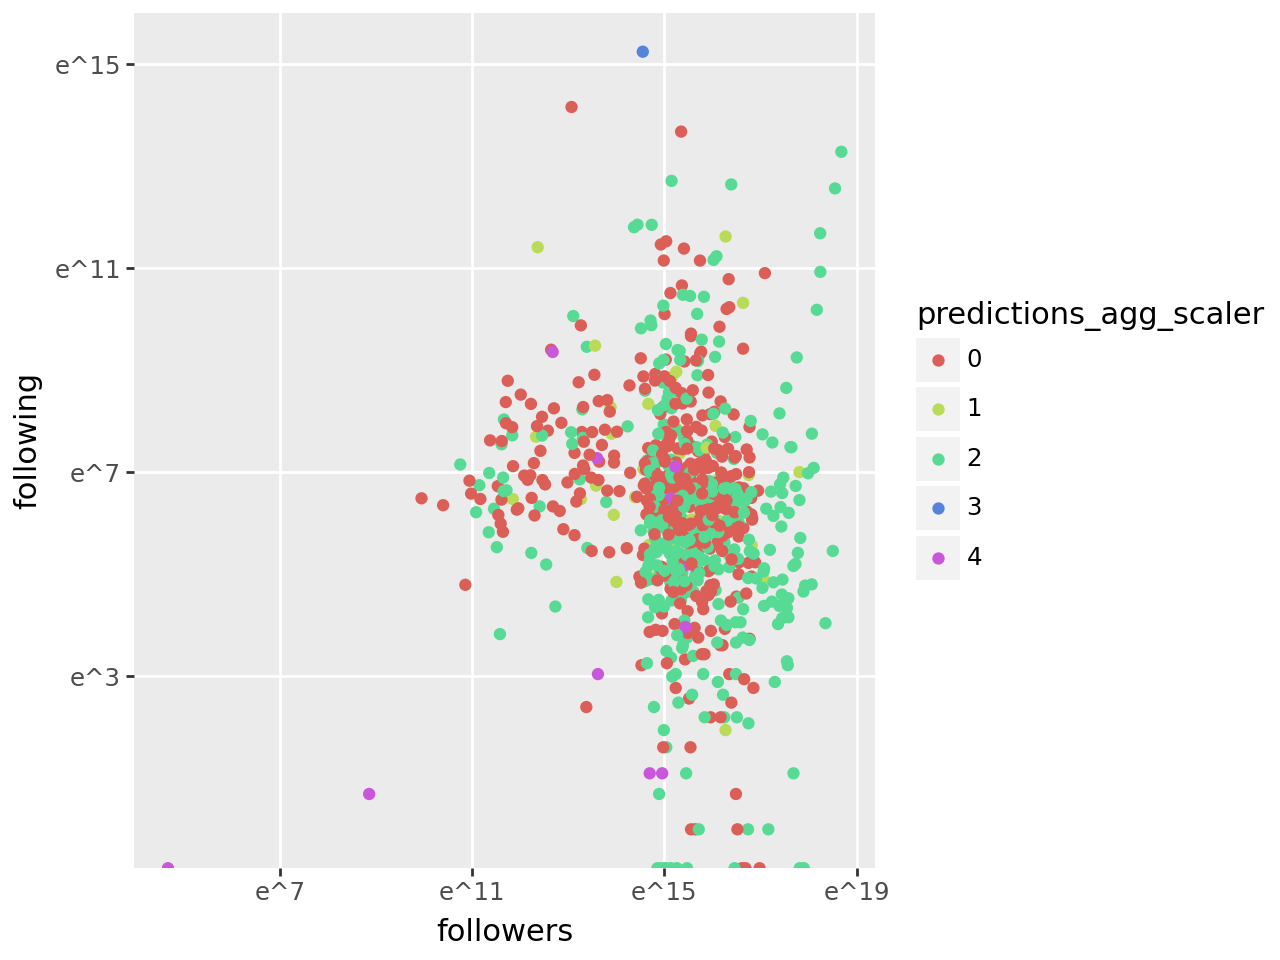

In [1612]:
##Visualizamos
#Vemos que ya es mas complejo ver que esta pasando en la gráfica
#pero los graficos sigeuen siendo similares a los anteriores a pesar de que hay algunas doferencias
graph = (
    pn.ggplot(user_stats, pn.aes(x='followers', y='following', color='predictions_agg_scaler'))
    + pn.geom_point()
    + pn.scale_x_continuous(trans='log')
    + pn.scale_y_continuous(trans='log')
)

graph

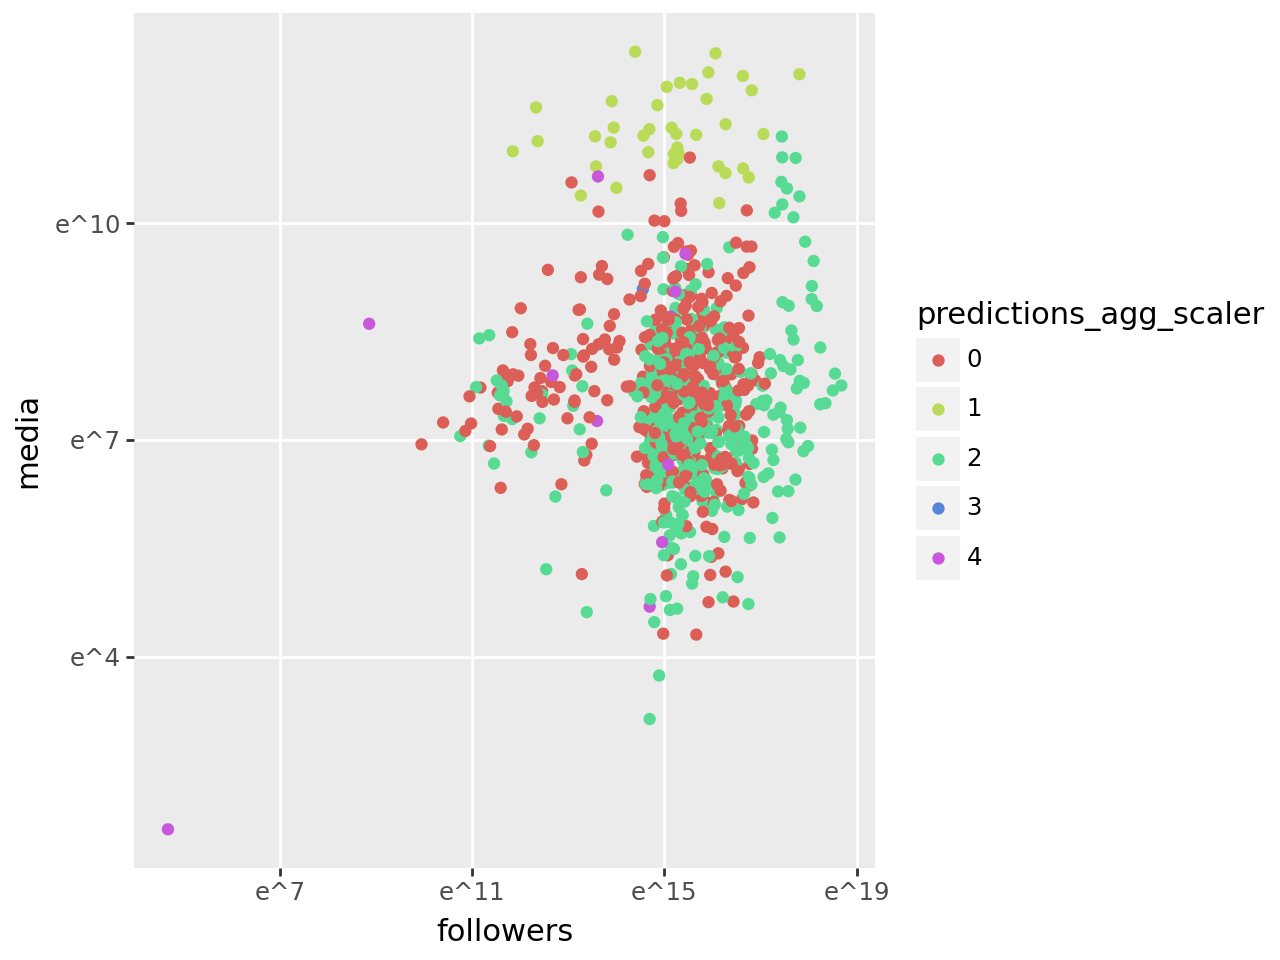

In [1613]:
graph = (
    pn.ggplot(user_stats, pn.aes(x='followers', y='media', color='predictions_agg_scaler'))
        + pn.geom_point()
        + pn.scale_x_continuous(trans='log')
        + pn.scale_y_continuous(trans='log')
)

graph

C:\Users\nuria\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log


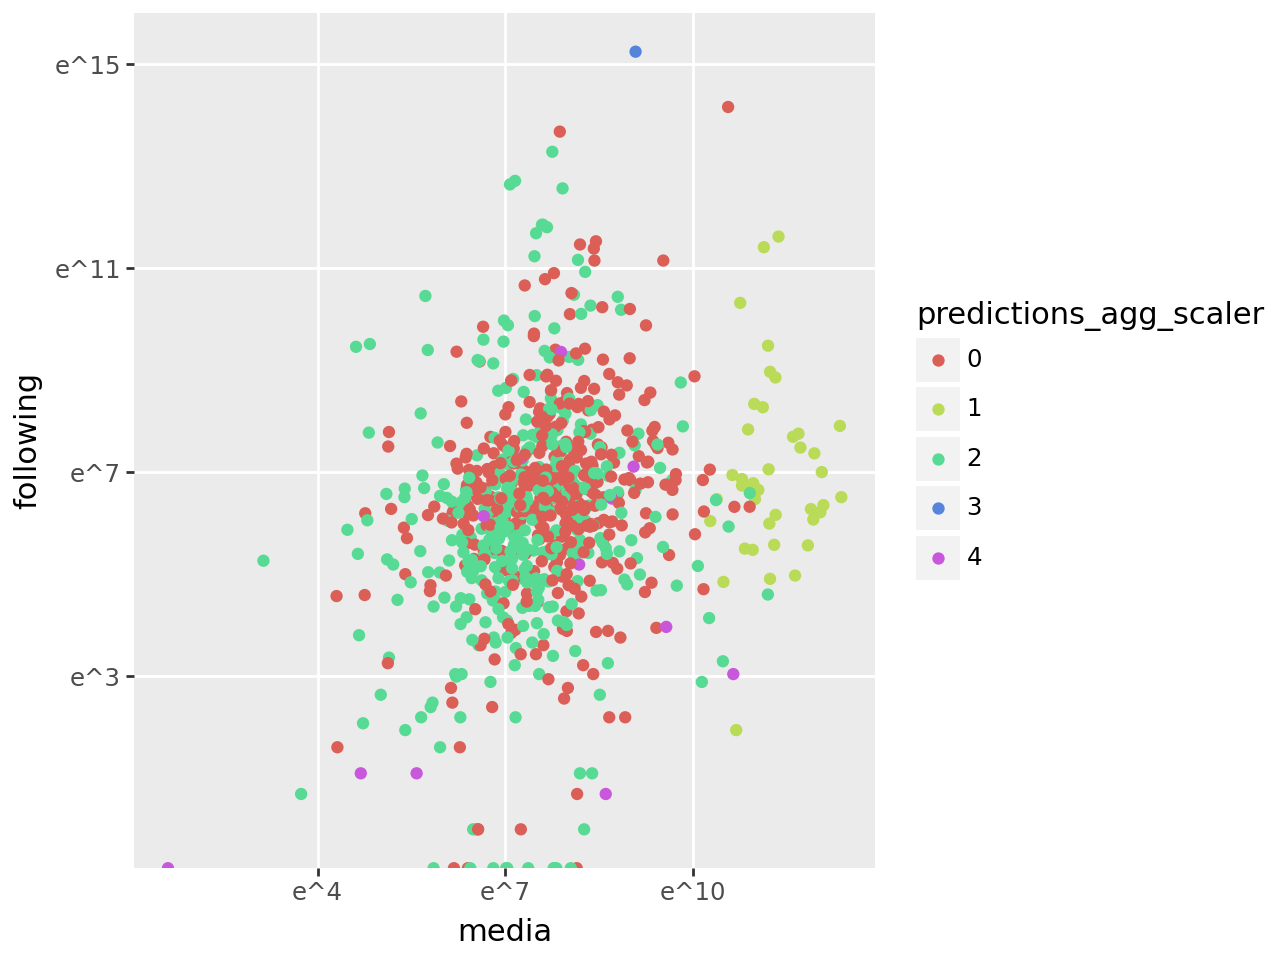

In [1614]:
 graph = (
    pn.ggplot(user_stats, pn.aes(x='media', y='following', color='predictions_agg_scaler'))
    + pn.geom_point()
    + pn.scale_x_continuous(trans='log')
    + pn.scale_y_continuous(trans='log')
)

graph

C:\Users\nuria\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log


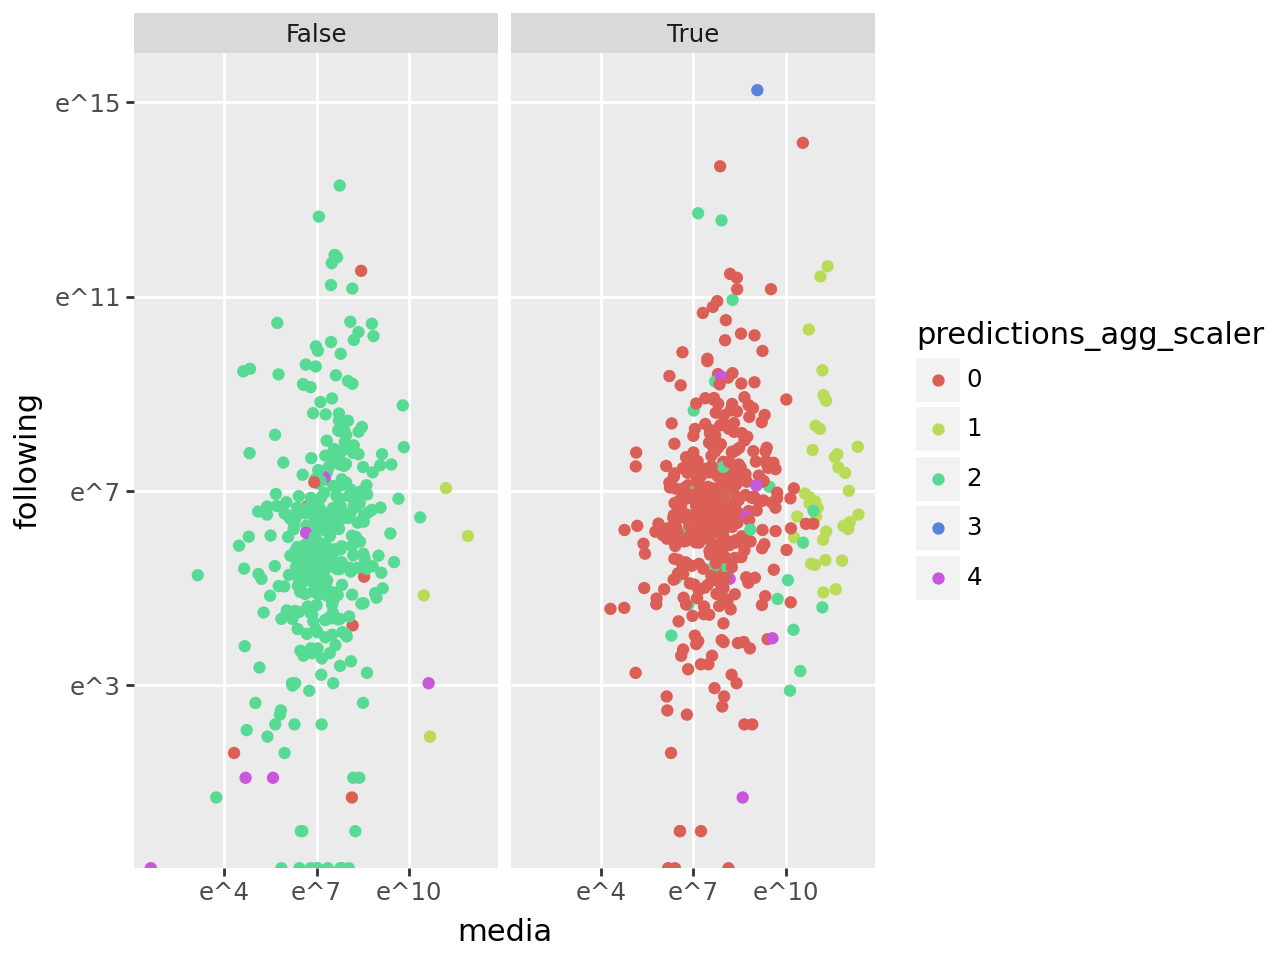

In [1615]:
 #resultados  similares a los vistos en KMeans
#con variables categoricas, somos capaces de diferenciar en otro eje también
#Aqui podemos ver que se han dividio varios clusters en funcion de si tienen o no retweets
#casi todos los del cluster 2 pertenecen al grupo de los que no tienen retweets
#Los de los clusters 0 y 1 casi todos pertenecen al grupo de los que tienen retweets
graph = (
    pn.ggplot(user_stats, pn.aes(x='media', y='following', color='predictions_agg_scaler'))
    + pn.geom_point()
    + pn.scale_x_continuous(trans='log')
    + pn.scale_y_continuous(trans='log')
    + pn.facet_wrap('~has_retweets')
)

graph

In [1616]:
#veremos el dendogram 
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

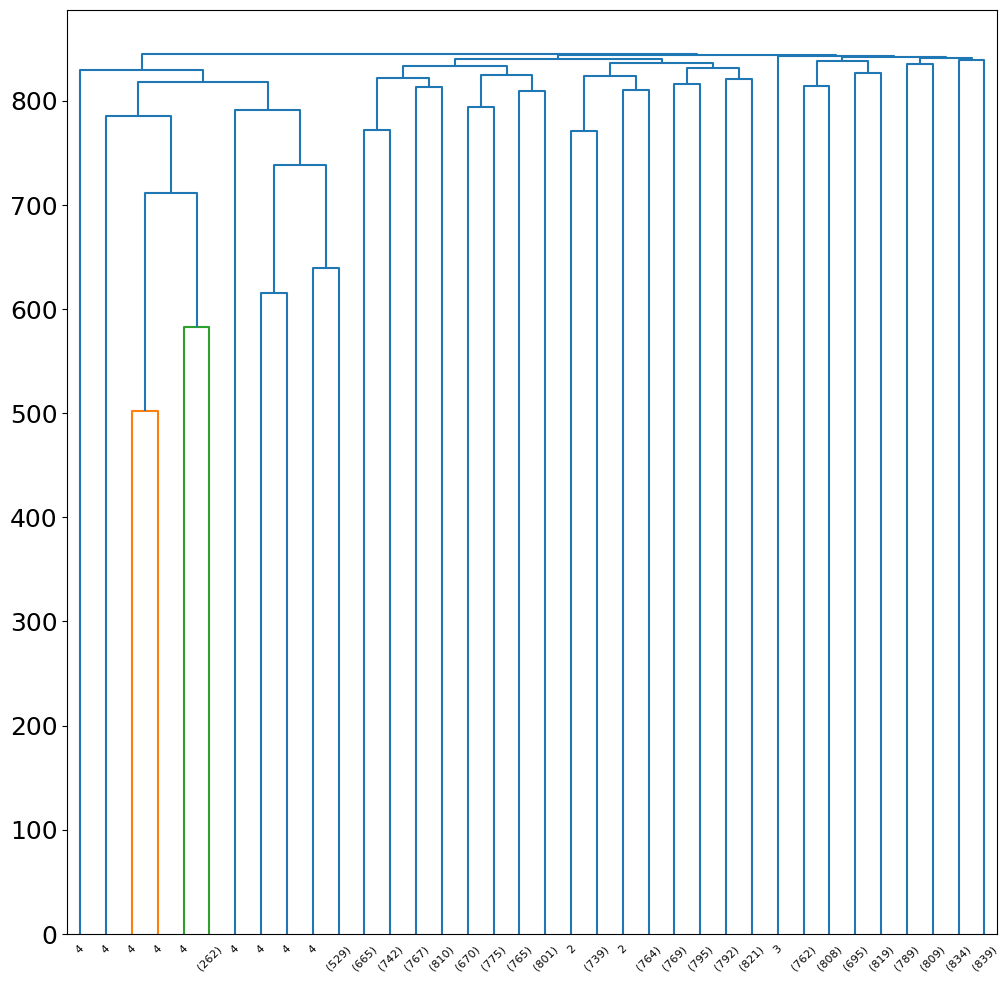

In [1617]:
#visualizamos dendogram
#A mas distancia hay mas diferentes son
#Una tecnica bastante usada es el hecho de cortar el dendograma
#a mas cerca estan las lineas mas similitud hay entre clsuters
plt.figure(figsize=(12, 12))
plot_dendrogram(agg_pipeline['cluster'], labels=agg_pipeline['cluster'].labels_, truncate_mode='level', p=5)
plt.show()

# Casos de uso

In [1619]:
#Vamos a detectar unos grupos de interes y también usarlo en un algoritmo predictivo.
cols = ['followers', 'nlikes', 'nreplies', 'nretweets']
user_stats.predictions_kmeans_5_scaler.value_counts()

predictions_kmeans_5_scaler
0    533
4    233
1     59
3     21
2      1
Name: count, dtype: int64

In [1620]:
#Cogemos los clusters que sacamos de nuestro KMeans 
#Cogemos la media de likes, respuestas y retweets que tenian de sus tweets en el periodo que analizamos.
#Vemos que hay bastante diferencia entre los clusters y como la gente interactua con su contenido.
#El cluster 2 tiene followers similares al 3 pero muchos menos lines y menos replies y retweets
user_stats.groupby('predictions_kmeans_5_scaler')[cols].mean()

,followers,nlikes,nreplies,nretweets
predictions_kmeans_5_scaler,,,,
0,6.370244e+06,3184.885325,242.844900,585.924640
1,4.022174e+07,15522.093215,489.796666,1683.699265
2,2.088502e+06,27.338983,3.101695,8.542373
3,2.729732e+06,4165.071607,498.218824,660.301933
4,7.283223e+06,17155.263097,685.889815,3257.654762


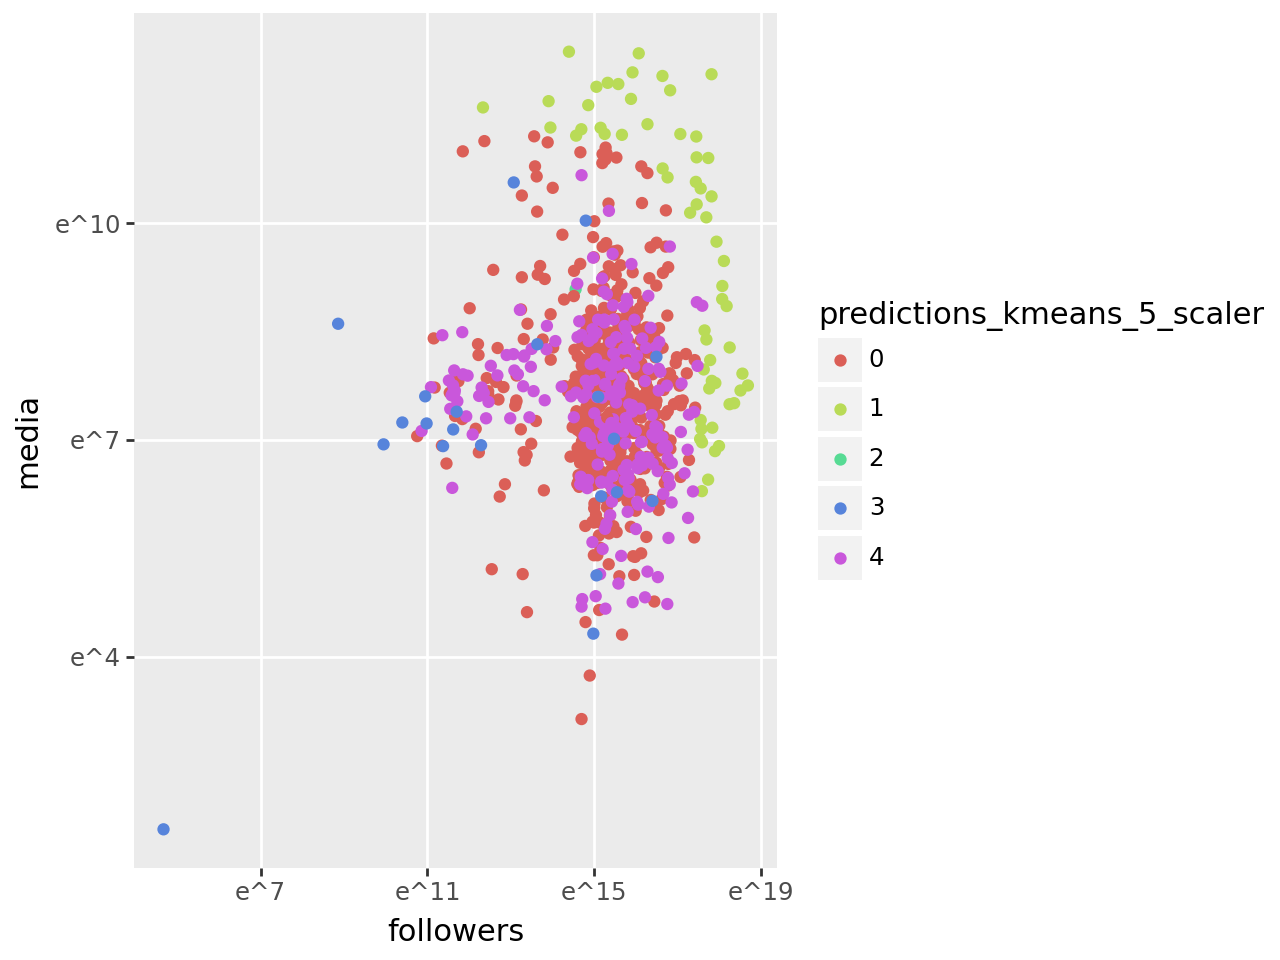

In [1621]:
#Visualizamos los datos de nuevo 
graph = (
    pn.ggplot(user_stats, pn.aes(x='followers', y='media', color='predictions_kmeans_5_scaler'))
    + pn.geom_point()
    + pn.scale_x_continuous(trans='log')
    + pn.scale_y_continuous(trans='log')
)

graph


## Utilizar los clusters con un modelo: regresion lineal

In [1623]:
#hacemos una regresion para poder predecir el numero de likes de un tweet
from sklearn.linear_model import LinearRegression
#usaremos variables followers y video
X_variables = ['followers', 'video']
y_variable = 'nlikes'

In [1624]:
model = LinearRegression()
#pasaremos fit y target porque ya estamos ante un problema supervisado
model.fit(tweet_data[X_variables], tweet_data[y_variable])
#el score es una variacion interna que tiene la regresion lineal, es la distacia entre lo 'real' y lo predicho
model.score(tweet_data[X_variables], tweet_data[y_variable])

0.009980522620330556

In [1625]:
#podemos combinar los datos de kmeans para detectar los grupos de interés y utilizarlo como otra variable
cols_tweets = X_variables + ['id_user', y_variable]
cols_user = ['id_user', 'predictions_kmeans_5_scaler']
combined_data = tweet_data[cols_tweets].merge(user_stats[cols_user])

In [1626]:
#entrenamos el modelo de regresion con nuestras variables y nuestros grupos de interes
model = LinearRegression()
model.fit(combined_data[X_variables + ['predictions_kmeans_5_scaler']], combined_data[y_variable])
model.score(combined_data[X_variables + ['predictions_kmeans_5_scaler']], combined_data[y_variable])

0.012386830777141866

# Reduccion dimensiones

## PCA

In [1629]:
from sklearn.decomposition import PCA
variables = [col for col in user_stats if user_stats[col].dtypes in [int, float] and col not in ['id_user']]
user_stats[variables].head()

,nlikes,nreplies,nretweets
0,1699.081081,155.418919,574.175676
1,13.000000,1.714286,1.714286
2,1631.545455,417.424242,424.303030
3,22.675676,1.702703,10.153153
4,734.868481,103.995465,296.519274


In [1630]:
#Especificamos numero de componentes
#Sacara dos de los componentes mas importantes
ncomponents = 2
pca_pipeline = Pipeline(
    [
        ('scaler', preprocessing.StandardScaler()),
        ('pca', PCA(ncomponents, random_state=0))
    ]
)
#aprende como tiene que hacer la deconstruccion
pca_pipeline.fit(user_stats[variables])

cols = ['component_' + str(i + 1) for i in range(ncomponents)]
#luego expresa con el transform los datos en base a los componentes principales que sacamos antes
transformed_data = pd.DataFrame(pca_pipeline.transform(user_stats[variables]), columns=cols)

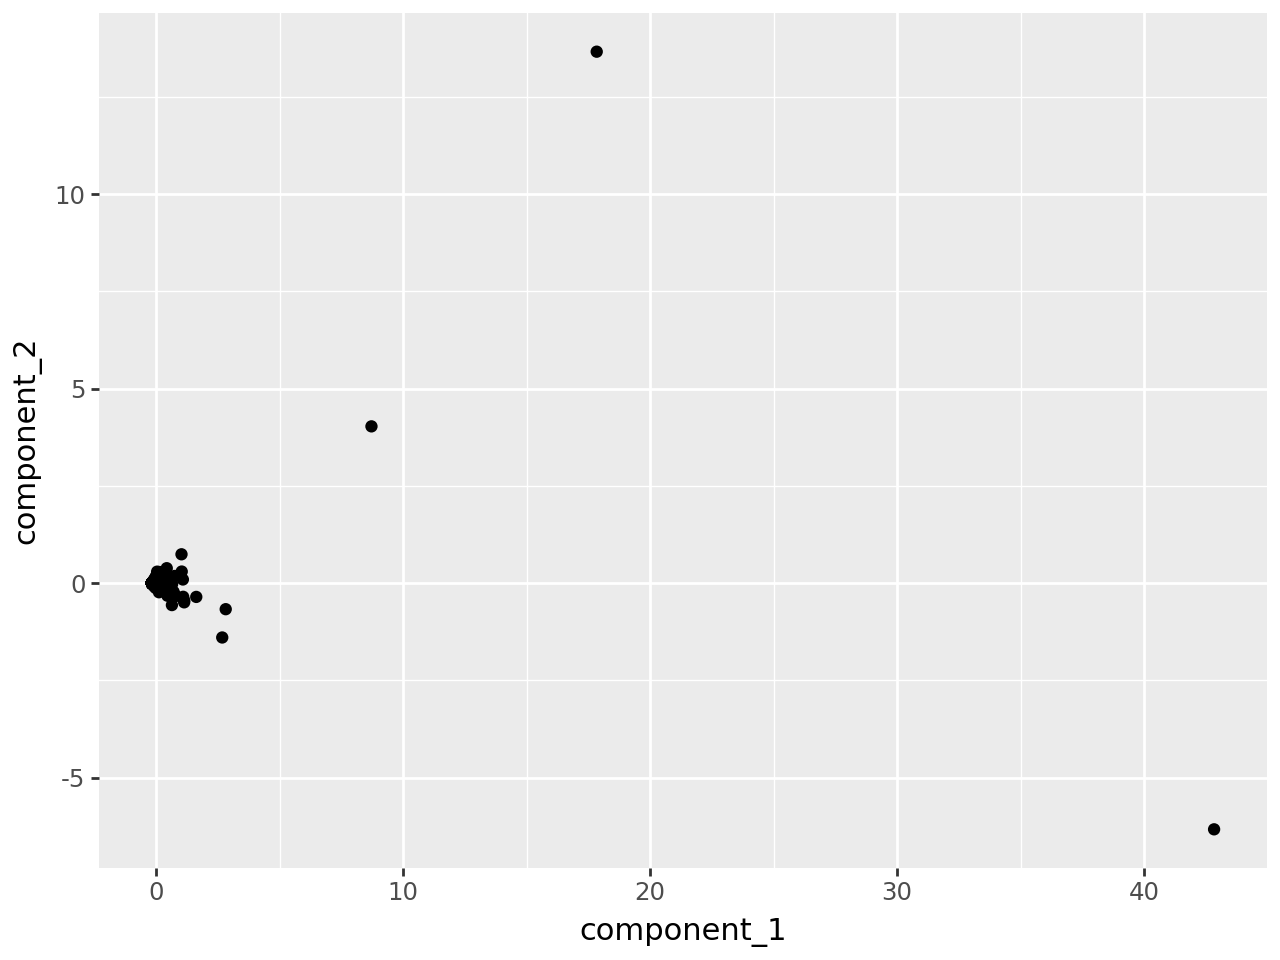

In [1631]:
graph = (
    #dibujamos el grafico en bse al primer componente y en base al segundo componente
    pn.ggplot(transformed_data, pn.aes(x='component_1', y='component_2'))
    + pn.geom_point()
)

graph

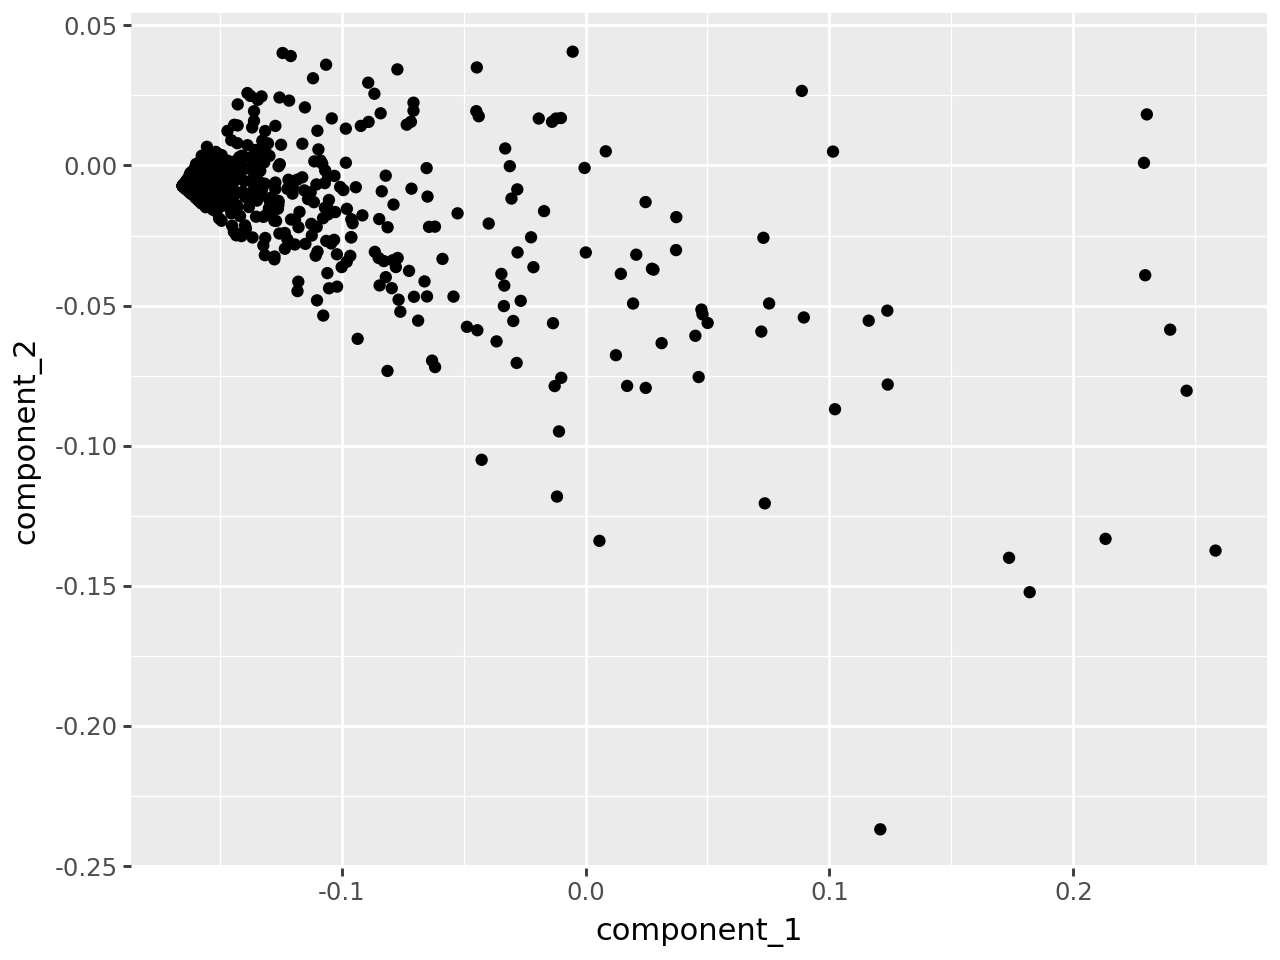

In [1632]:
#Haremos una especie de zoom en el grafico para poder onservar con mas detalle
limit_x = transformed_data.component_1.quantile(0.95)
limit_y = transformed_data.component_2.quantile(0.95)

condition = (transformed_data.component_1 < limit_x) & (transformed_data.component_2 < limit_y)

graph = (
    pn.ggplot(transformed_data[condition], pn.aes(x='component_1', y='component_2'))
    + pn.geom_point()
)

graph

## T-SNE

In [1635]:
from pca import pca
from sklearn.manifold import TSNE

In [1644]:
ncomponents = 2
tsne_pipeline = Pipeline(
    [
        ('scaler', preprocessing.StandardScaler()),
        ('pca', PCA(random_state=0)),
        ('tsne', TSNE(ncomponents, random_state=0))
    ]
)

cols = ['component_' + str(i + 1) for i in range(ncomponents)]
transformed_data = pd.DataFrame(tsne_pipeline.fit_transform(user_stats[variables]), columns=cols)

In [1645]:
#junto los datos tranformados con los datos que teniamos de las variables antes para visualizarlo mejor
transformed_data = pd.concat([transformed_data, user_stats[['id_user'] + variables]], axis=1)


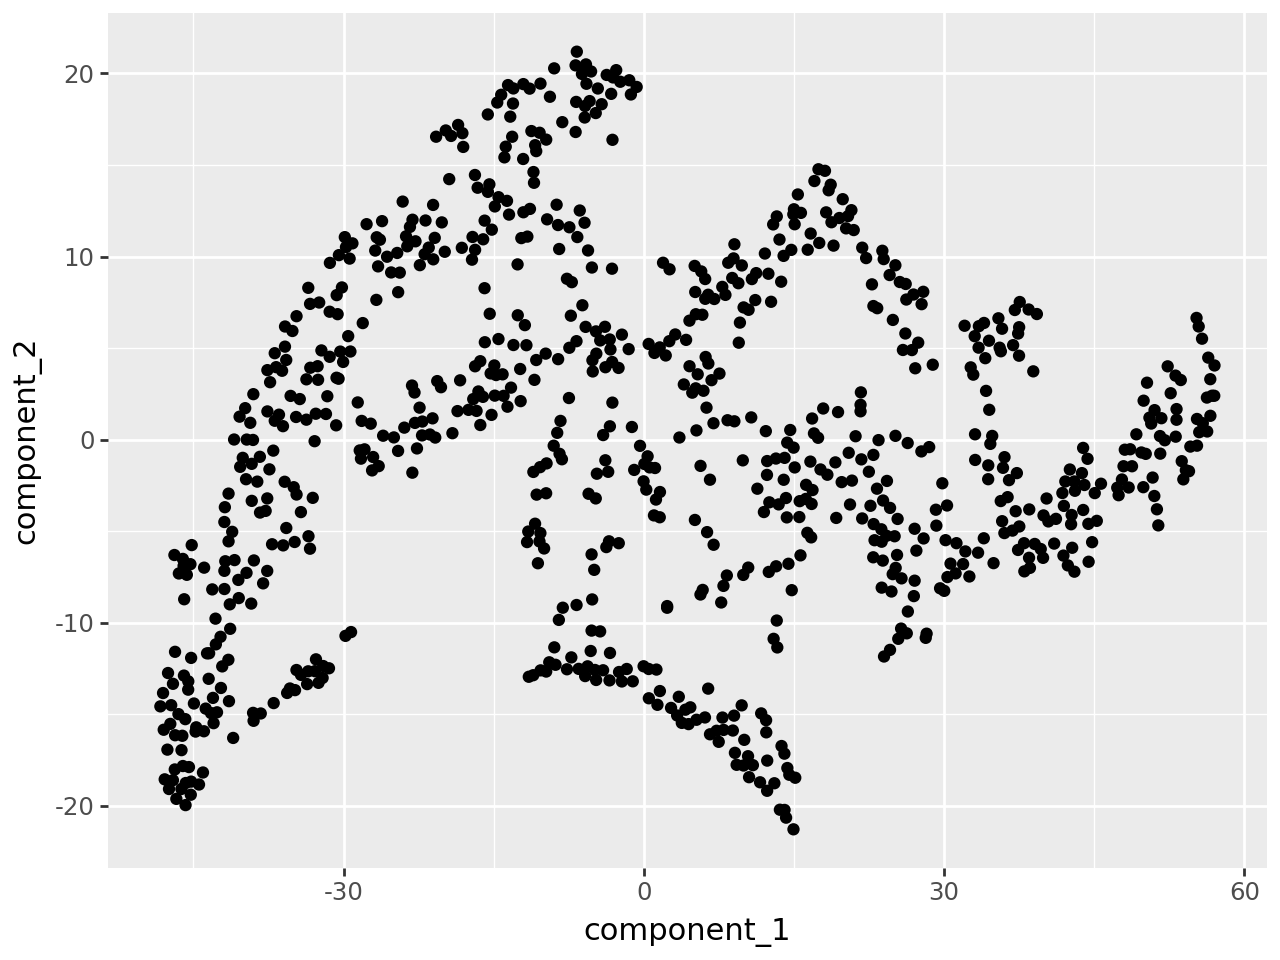

In [1646]:
graph = (
    pn.ggplot(transformed_data, pn.aes(x='component_1', y='component_2'))
    + pn.geom_point()
)

graph

# Reducción de dimensiones: aplicando las tecnicas

In [1650]:
#empleamos un KMeans sobre los resultados del t-SNE 
X_variables = ['component_1', 'component_2']

kmeans_tsne_pipeline = Pipeline(
    [
        ('scaler', preprocessing.StandardScaler()),
        ('cluster', KMeans(n_clusters=5, random_state=0))
    ]
)

kmeans_tsne_pipeline.fit(transformed_data[X_variables])
predictions = kmeans_tsne_pipeline.predict(transformed_data[X_variables])
pd.DataFrame(predictions).value_counts()

0
1    213
0    185
2    163
4    159
3    127
Name: count, dtype: int64

In [1652]:
#calculamos silhouette y veremos que ha bajado
metrics.silhouette_score(kmeans_tsne_pipeline['scaler'].transform(transformed_data[X_variables]), predictions)

0.38945857

In [1654]:
transformed_data['predictions_kmeans_5_scaler'] = predictions.astype(str)

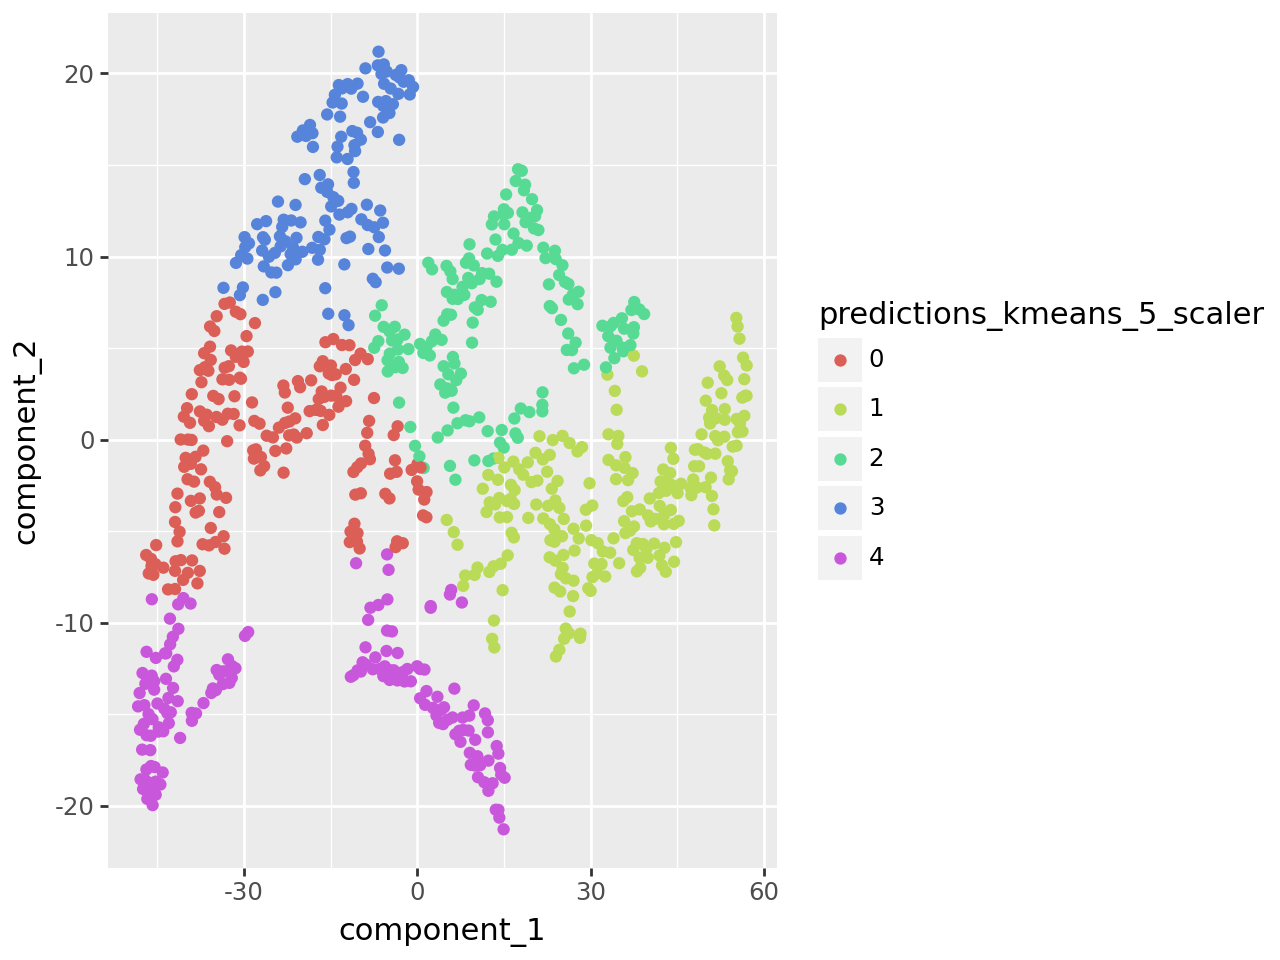

In [1656]:
#vemos unos patrones similares a antes:
graph = (
    pn.ggplot(transformed_data, pn.aes(x='component_1', y='component_2', color='predictions_kmeans_5_scaler'))
    + pn.geom_point()
)

graph

In [1662]:
cols = [col for col in transformed_data if col not in X_variables + ['predictions_kmeans_5_scaler']]

In [1664]:
transformed_data.groupby('predictions_kmeans_5_scaler')[cols].mean()

,id_user,nlikes,nreplies,nretweets
predictions_kmeans_5_scaler,,,,
0,1.014568e+08,230.193460,10.237568,41.527386
1,1.682531e+16,29607.800502,1350.285616,4921.216305
2,1.313137e+16,1635.315990,199.403687,252.021885
3,2.154065e+16,237.241582,33.693701,36.921076
4,1.352946e+16,328.830426,14.626867,521.222322


In [1668]:
#Vamos a probar a utilizar esto en nuestra regresion 

from sklearn.linear_model import LinearRegression
X_variables = ['followers', 'video']
y_variable = 'nlikes'

cols_tweets = X_variables + ['id_user', y_variable]
cols_trans = ['id_user', 'predictions_kmeans_5_scaler', 'component_1', 'component_2']
combined_data = tweet_data[cols_tweets].merge(transformed_data[cols_trans], on='id_user')

In [1672]:
tweet_data.shape

(40581, 56)

In [1670]:
combined_data.shape

(40581, 7)

In [1674]:
#empleando linear regression con el modelo original 
model = LinearRegression()
model.fit(combined_data[X_variables], combined_data[y_variable])
model.score(combined_data[X_variables], combined_data[y_variable])

0.009980522620330556

Comprobamos que mejora el resultado al emplear linear regression en clusters y componentes

In [1676]:
#empleando linear regression con los clusters
model = LinearRegression()
model.fit(combined_data[X_variables + ['predictions_kmeans_5_scaler']], combined_data[y_variable])
model.score(combined_data[X_variables + ['predictions_kmeans_5_scaler']], combined_data[y_variable])

0.010573239971902959

In [1678]:
#empleando linear regression con los componentes

odel = LinearRegression()
model.fit(combined_data[['component_1', 'component_2']], combined_data[y_variable])
model.score(combined_data[['component_1', 'component_2']], combined_data[y_variable])

0.02481544017791748